# Cancer Detection CNN

## Introduction

### Problem and Data

This Problem involves identifying metastatic cancer in small image patches taken from larger digital pathology scans. The dataset contains over 270,000 scan images in tif format. The "train_labels.csv" provides ground truth for train dataset, and contains two classes, 0 and 1. So this is a binary classification problem. Considering the large amount of data, it makes sense to train a nerual network model, and since the input are images, we will train a convolutional nerual network(CNN) as CNN can learn spatial hierarchies of features very well.

### Import Library

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import pathlib
import matplotlib.pyplot as plt
from PIL import Image
import math
import time
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Dropout, BatchNormalization
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2


In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    for gpu in physical_devices:
        tf.config.experimental.set_memory_growth(gpu, True)
    

### Load Date

In [3]:
train_path = '/kaggle/input/histopathologic-cancer-detection/train'
test_path = '/kaggle/input/histopathologic-cancer-detection/test'
train_dir = pathlib.Path(train_path).with_suffix('')
test_dir = pathlib.Path(test_path).with_suffix('')

train_imgs = list(train_dir.glob('*.tif'))
test_imgs = list(test_dir.glob('*.tif'))
train_labels = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')


print(len(train_imgs))
print(len(test_imgs))
print(len(train_labels))

220025
57458
220025


In [5]:
# check image file name
train_imgs[0]

PosixPath('/kaggle/input/histopathologic-cancer-detection/train/d43c081bafa286f9c1f7e921883f26ceafebc912.tif')

## Exploratory Data Analysis (EDA)

### View Images

In [4]:
def plot_imgs(img_paths, cols=3, figsize=(15,15), titles=None):
    rows = math.ceil(len(img_paths) / cols)
    plt.figure(figsize=figsize)
    for i, img_path in enumerate(img_paths):
        img = Image.open(img_path)    
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.title(img_path.stem if titles is None else titles[i])
        plt.axis('off')  
    plt.tight_layout()
    plt.show()

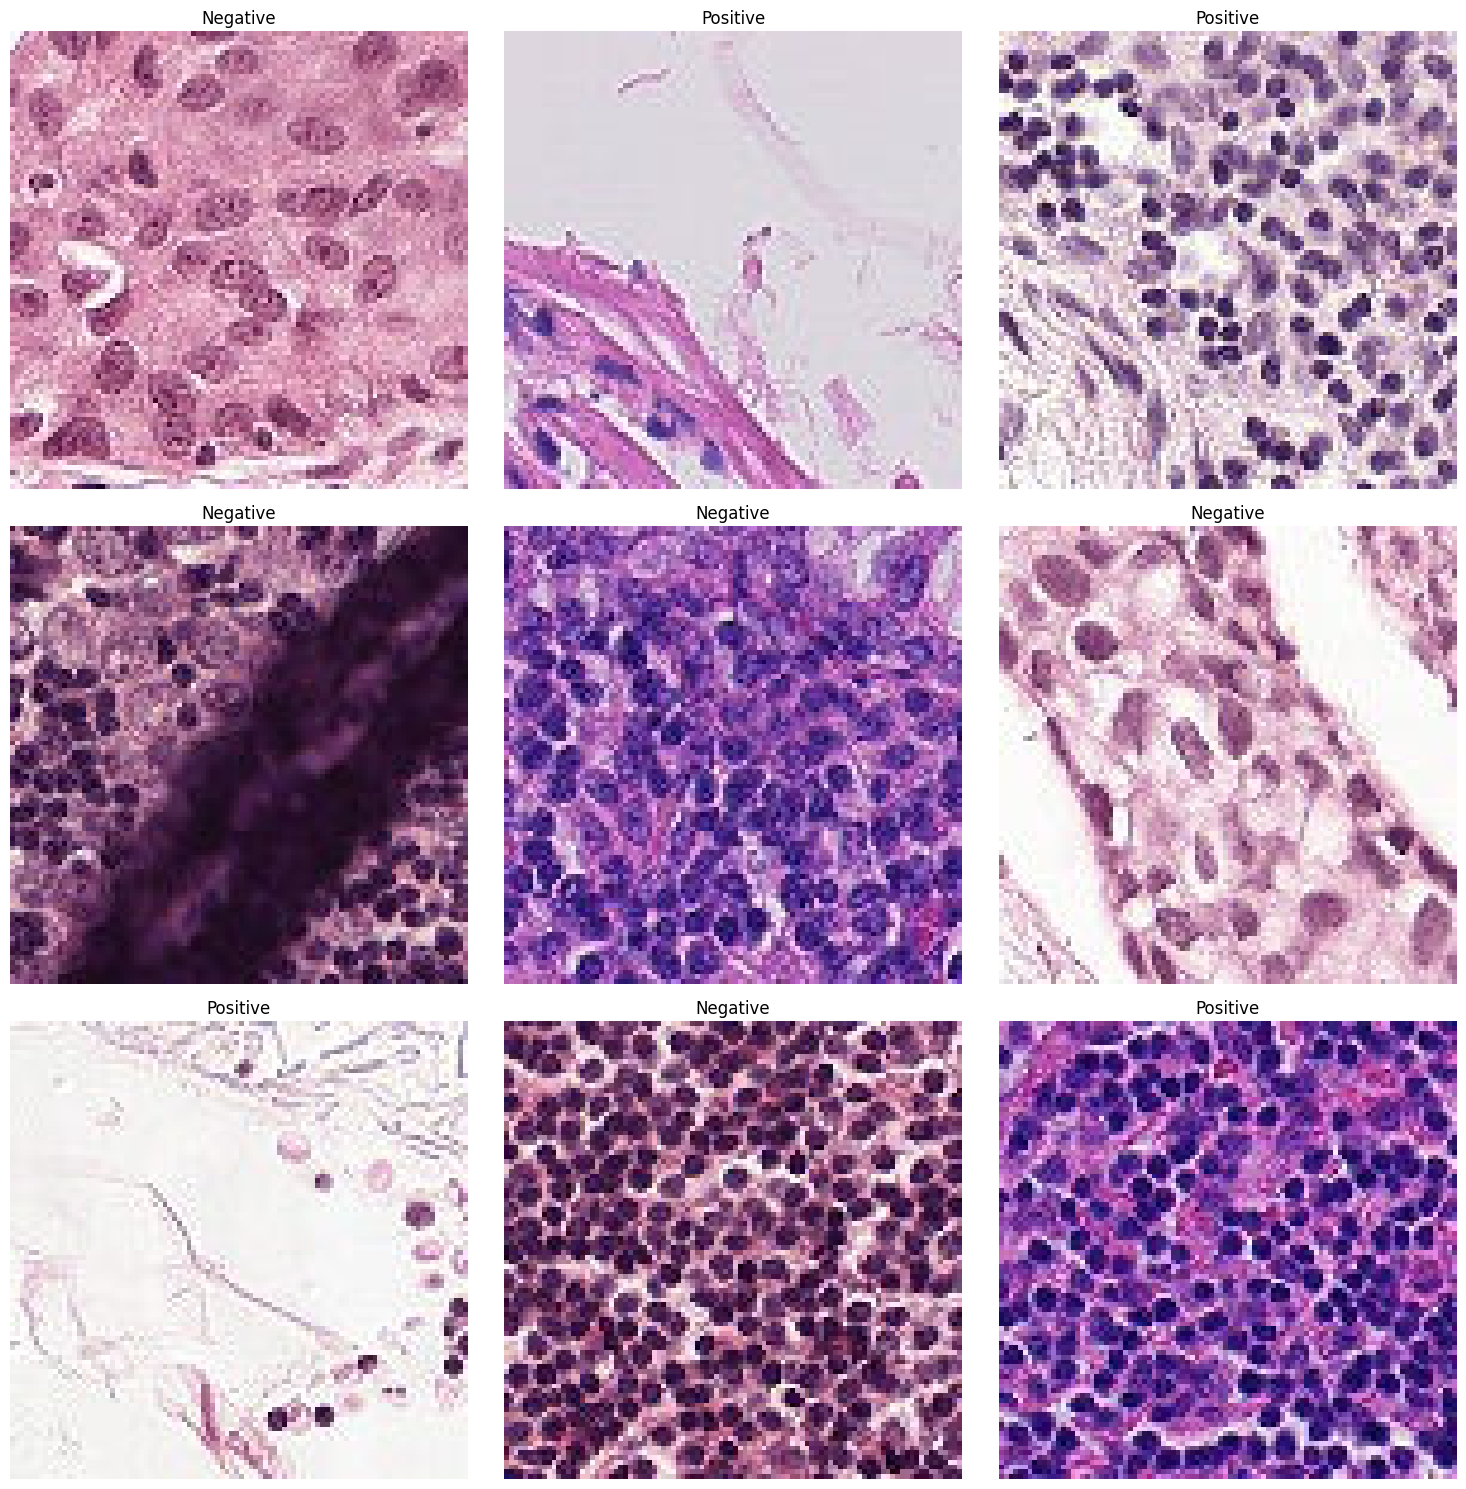

In [7]:
display_imgs = train_imgs[:9]
ids = [i.stem for i in display_imgs]
labels = train_labels[train_labels['id'].isin(ids)]['label'].tolist()
titles = ["Positive" if i == 1 else "Negative" for i in labels]
plot_imgs(display_imgs, titles=titles)

###  Inspect and Visualize Train_Labels

In [6]:
train_labels.head(10)

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0
5,acfe80838488fae3c89bd21ade75be5c34e66be7,0
6,a24ce148f6ffa7ef8eefb4efb12ebffe8dd700da,1
7,7f6ccae485af121e0b6ee733022e226ee6b0c65f,1
8,559e55a64c9ba828f700e948f6886f4cea919261,0
9,8eaaa7a400aa79d36c2440a4aa101cc14256cda4,0


Label counts: label
0    130908
1     89117
Name: count, dtype: int64


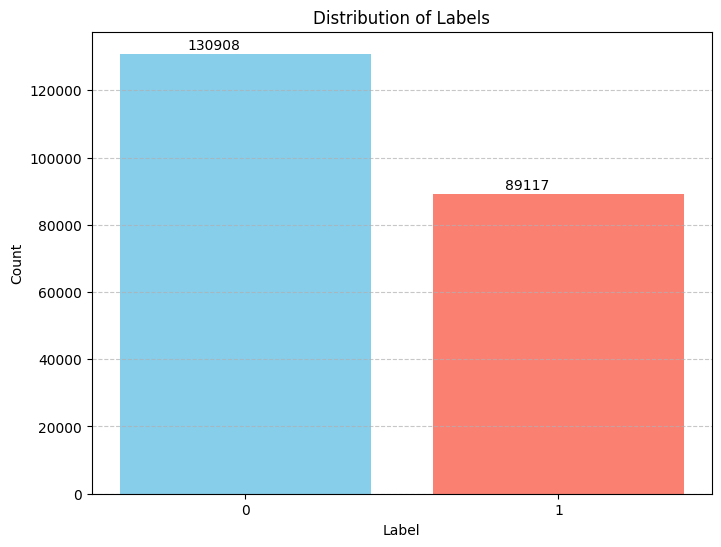

In [9]:

label_counts = train_labels['label'].value_counts()
print(f"Label counts: {label_counts}")
plt.figure(figsize=(8, 6))
# label_counts.plot(kind='bar', color=['skyblue', 'salmon'])
bars = plt.bar(label_counts.index, label_counts.values, color=['skyblue', 'salmon'])
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2 - 0.1, yval + 500, int(yval), ha='center', va='bottom')
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(ticks=label_counts.index, labels=label_counts.index, rotation=0) 
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#### The train dataset contains 130k datapoints label of 0, and 90k datapoints label of 1. The train dataset is roughly balanced.

## Model

### Prepare Data

The original image format is tif, we want to use imagedatagenerator to preprocess image data and perform data augmentation, normalization, and batch process at once.

In [6]:
t0 = time.time()
train_df = pd.DataFrame(train_labels)
train_df['id'] = train_df['id'] + '.tif'
train_df['label'] = train_df['label'].astype(str)
img_size = (96, 96)
batch_size = 32
# for simplicity, do not perform data augmentation for now
datagen = ImageDataGenerator(
    rescale=1.0/255.0,        # Normalize pixel values to [0, 1]
    validation_split=0.1,
#     rotation_range=40,       
#     width_shift_range=0.2,   
#     height_shift_range=0.2,  
#     shear_range=0.2,         
    zoom_range=0.2,         
    horizontal_flip=True,    
#     fill_mode='nearest'      
)

train_generator = datagen.flow_from_dataframe(
        directory = train_dir,
        dataframe = train_df,
        x_col = 'id',
        y_col = 'label',
        subset = "training",
        seed = 123,
        shuffle=True,
        target_size = img_size,
        batch_size = batch_size,
        class_mode = 'binary',
        color_mode = "rgb"   
)
val_generator = datagen.flow_from_dataframe(
        directory = train_dir,
        dataframe = train_df,
        x_col = 'id',
        y_col = 'label',
        subset = "validation",
        seed = 123,
        shuffle=True,
        target_size = img_size,
        batch_size = batch_size,
        class_mode = 'binary',
        color_mode = "rgb"    
)
t1 = time.time()
print(f'excution time: {(t1 - t0) / 60} mins')

Found 198023 validated image filenames belonging to 2 classes.
Found 22002 validated image filenames belonging to 2 classes.
excution time: 4.684618659814199 mins


### Baseline Model


In [6]:
# model = Sequential([
#     Input(shape=(96, 96, 3)),
#     Conv2D(32, (3, 3), activation='relu'),
#     MaxPooling2D(2, 2),
#     Conv2D(64, (3, 3), activation='relu'),
#     MaxPooling2D(2, 2),
#     Conv2D(128, (3, 3), activation='relu'),
#     MaxPooling2D(2, 2),
#     Flatten(),
#     Dense(512, activation='relu'),
#     Dense(1, activation='sigmoid') 
# ])
# model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     6,554,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,647,873 (25.36 MB)

 Trainable params: 6,647,873 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
# adam default learning rate = 0.001, we can tune learning rate later
lr = 0.001
# model.compile(optimizer=Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy'])

In [27]:
# epochs = 10
# history = model.fit(
#     train_generator,
#     epochs=epochs,
#     validation_data=val_generator    
# )

Epoch 1/10
6189/6189 ━━━━━━━━━━━━━━━━━━━━ 323s 52ms/step - accuracy: 0.7903 - loss: 0.4533 - val_accuracy: 0.8506 - val_loss: 0.3544
Epoch 2/10
6189/6189 ━━━━━━━━━━━━━━━━━━━━ 316s 51ms/step - accuracy: 0.8682 - loss: 0.3109 - val_accuracy: 0.8917 - val_loss: 0.2716
Epoch 3/10
6189/6189 ━━━━━━━━━━━━━━━━━━━━ 309s 50ms/step - accuracy: 0.8939 - loss: 0.2594 - val_accuracy: 0.9010 - val_loss: 0.2427
Epoch 4/10
6189/6189 ━━━━━━━━━━━━━━━━━━━━ 316s 51ms/step - accuracy: 0.9104 - loss: 0.2250 - val_accuracy: 0.9037 - val_loss: 0.2476
Epoch 5/10
6189/6189 ━━━━━━━━━━━━━━━━━━━━ 321s 51ms/step - accuracy: 0.9232 - loss: 0.1927 - val_accuracy: 0.9081 - val_loss: 0.2337
Epoch 6/10
6189/6189 ━━━━━━━━━━━━━━━━━━━━ 312s 50ms/step - accuracy: 0.9384 - loss: 0.1586 - val_accuracy: 0.9064 - val_loss: 0.2467
Epoch 7/10
6189/6189 ━━━━━━━━━━━━━━━━━━━━ 310s 50ms/step - accuracy: 0.9534 - loss: 0.1222 - val_accuracy: 0.9039 - val_loss: 0.2766
Epoch 8/10
6189/6189 ━━━━━━━━━━━━━━━━━━━━ 312s 50ms/step - accuracy: 

## Results and Analysis

### Evaluate Baseline Model

In [7]:
def draw_learning_curve(history):
    acc, val_acc = history.history['accuracy'], history.history['val_accuracy']
    loss, val_loss = history.history['loss'], history.history['val_loss']
    
    plt.figure(figsize=(8,8))
    plt.subplot(2,1,1)
    plt.plot(acc, label="Train Accuracy")
    plt.plot(val_acc, label="Validation Accuracy")
    plt.ylabel("Accuracy")
    plt.ylim([min(plt.ylim()),1.])
    plt.title("Train and Validation Accuracy")
    plt.legend()
    
    plt.subplot(2,1,2)
    plt.plot(loss, label="Train Loss")
    plt.plot(val_loss, label="Validation Loss")
    plt.ylabel("Loss")
    plt.ylim([0,1.])
    plt.xlabel("Epochs")
    plt.title("Train and Validation Loss")
    plt.legend()
    plt.show()

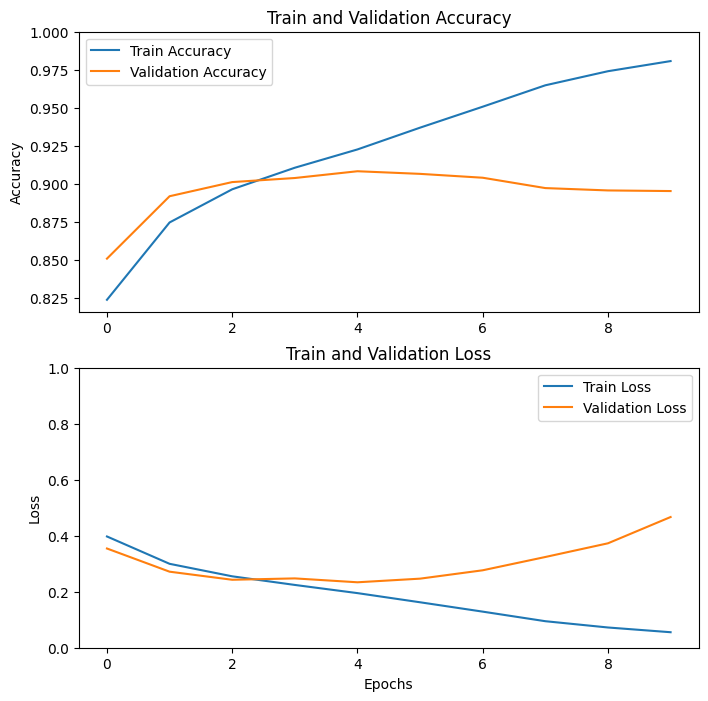

In [40]:
# draw_learning_curve(history)

### Analysis for Base Model

> #### After 10 epoches, our model ends up with training accuracy 0.9837, and validation accuracy 0.8951, which is relatively good. By observing the learning curve, we can see our model seems to overfit as after 2 or 3 epoches, the train accuracy kept increase, but the validation accuracy started decrease.

### How to Improve Base Model

> #### There are many tools to reduce overfitting issue, like data augmentation, dropout, batch normalization, early stopping.etc. Here, I would not use data augmentation as our baseline model already perform some data augmentation. I will use batch norm,dropout, l2 regularization, reduce complexity of model, and early stopping to tackle overfitting.

In [8]:
model_2 = Sequential([
    Input(shape=(96, 96, 3)),
    Conv2D(32, (3, 3), activation='relu',padding='same', kernel_regularizer=l2(0.001)),
#     BatchNormalization(),
    MaxPooling2D(2, 2),
#     Dropout(0.25),
    
    Conv2D(64, (3, 3), activation='relu',padding='same', kernel_regularizer=l2(0.001)),
#     BatchNormalization(),
    MaxPooling2D(2, 2),
#     Dropout(0.25),
        
    Conv2D(128, (3, 3), activation='relu',padding='same', kernel_regularizer=l2(0.001)),
#     BatchNormalization(),
    MaxPooling2D(2, 2),
#     Dropout(0.25),
        
    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)), 
#     Dropout(0.5),
    Dense(1, activation='sigmoid', kernel_regularizer=l2(0.001))
])

model_2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 96, 96, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     9,437,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,531,457 (36.36 MB)

 Trainable params: 9,531,457 (36.36 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
model_2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
epochs = 20
history_2 = model_2.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    callbacks=[early_stopping]
)

Epoch 1/20
3433/6189 ━━━━━━━━━━━━━━━━━━━━ 11:07 242ms/step - accuracy: 0.7881 - loss: 0.4892

I0000 00:00:1726283035.589017     159 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_1', 8 bytes spill stores, 8 bytes spill loads



6189/6189 ━━━━━━━━━━━━━━━━━━━━ 1674s 270ms/step - accuracy: 0.7958 - loss: 0.4752 - val_accuracy: 0.8353 - val_loss: 0.4047
Epoch 2/20
6189/6189 ━━━━━━━━━━━━━━━━━━━━ 810s 131ms/step - accuracy: 0.8355 - loss: 0.4047 - val_accuracy: 0.8508 - val_loss: 0.3855
Epoch 3/20
6189/6189 ━━━━━━━━━━━━━━━━━━━━ 812s 131ms/step - accuracy: 0.8460 - loss: 0.3885 - val_accuracy: 0.8576 - val_loss: 0.3763
Epoch 4/20
3874/6189 ━━━━━━━━━━━━━━━━━━━━ 4:34 119ms/step - accuracy: 0.8532 - loss: 0.3764

KeyboardInterrupt: 

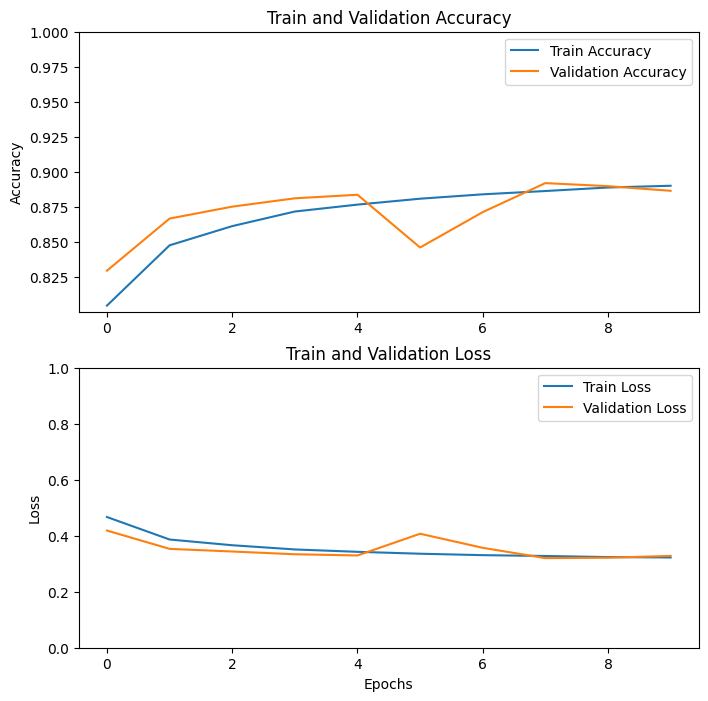

In [33]:
draw_learning_curve(history_2)

### Transfer Learning

#### Since we have a relatively large dataset, we can consider utilizing some pre trained model and fine tuning our own model. Transfer learning could save us a lot of time! 

In [ ]:
# try transfer learning
# from tensorflow.keras.applications import EfficientNetB0
# from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout
# from keras.applications.efficientnet_v2 import preprocess_input

# base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(96, 96, 3))

# inputs = Input(shape=(96,96,3))
# x = preprocess_input(inputs)
# x = base_model(x, training = False)
# x = GlobalAveragePooling2D()(x)
# x = Dense(512, activation='relu')(x)
# x = Dropout(0.5)(x)
# predictions = Dense(1, activation='sigmoid')(x)

# model_fine_tune = Model(inputs=inputs, outputs=predictions)
# model_fine_tune.summary()

In [ ]:
# model_fine_tune.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy'])
# early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# epochs = 20
# history_freeze = model_fine_tune.fit(
#     train_generator,
#     epochs=epochs,
#     validation_data=val_generator,
#     callbacks=[early_stopping]
# )



In [ ]:
# draw_learning_curve(history_freeze)

In [52]:
# model_fine_tune.trainable = True

# model_fine_tune.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# history_fine = model_fine_tune.fit(
#     train_generator,
#     epochs=epochs,
#     validation_data=val_generator,
#     callbacks=[early_stopping]
# )

Epoch 1/20
6189/6189 ━━━━━━━━━━━━━━━━━━━━ 345s 54ms/step - accuracy: 0.7101 - loss: 0.8018 - val_accuracy: 0.7122 - val_loss: 0.5454
Epoch 2/20
6189/6189 ━━━━━━━━━━━━━━━━━━━━ 321s 52ms/step - accuracy: 0.7678 - loss: 0.4974 - val_accuracy: 0.7493 - val_loss: 0.5184
Epoch 3/20
6189/6189 ━━━━━━━━━━━━━━━━━━━━ 320s 52ms/step - accuracy: 0.7766 - loss: 0.4779 - val_accuracy: 0.7420 - val_loss: 0.5113
Epoch 4/20
6189/6189 ━━━━━━━━━━━━━━━━━━━━ 327s 53ms/step - accuracy: 0.7859 - loss: 0.4628 - val_accuracy: 0.7859 - val_loss: 0.4582
Epoch 5/20
6189/6189 ━━━━━━━━━━━━━━━━━━━━ 332s 54ms/step - accuracy: 0.7910 - loss: 0.4519 - val_accuracy: 0.7741 - val_loss: 0.4812
Epoch 6/20
6189/6189 ━━━━━━━━━━━━━━━━━━━━ 333s 54ms/step - accuracy: 0.7980 - loss: 0.4436 - val_accuracy: 0.7852 - val_loss: 0.4392
Epoch 7/20
6189/6189 ━━━━━━━━━━━━━━━━━━━━ 321s 52ms/step - accuracy: 0.7997 - loss: 0.4379 - val_accuracy: 0.8027 - val_loss: 0.4300
Epoch 8/20
6189/6189 ━━━━━━━━━━━━━━━━━━━━ 320s 52ms/step - accuracy: 

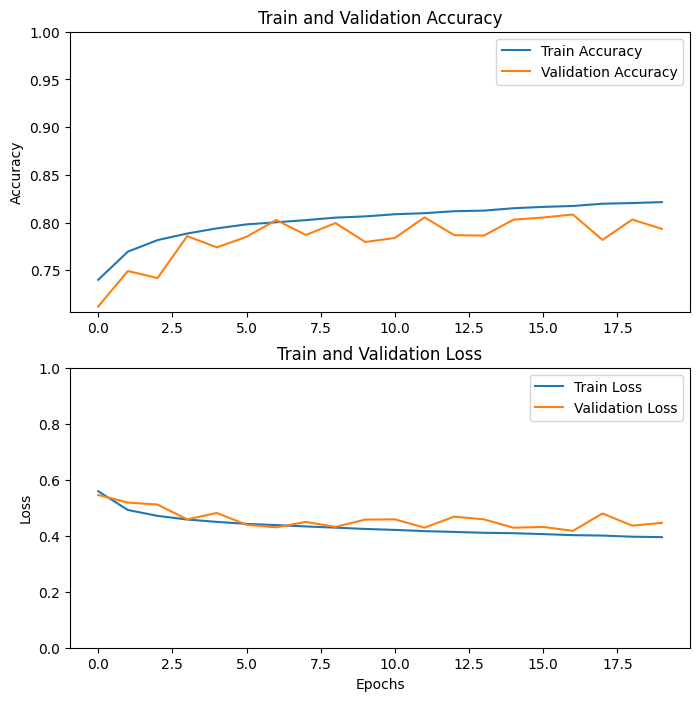

In [53]:
# draw_learning_curve(history_fine)

### Submission

In [22]:
test_path = '/kaggle/input/histopathologic-cancer-detection/test'

df_test = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/sample_submission.csv')
df_test['filename'] = df_test.id + '.tif'

test_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_generator = test_datagen.flow_from_dataframe(
    dataframe = df_test,
    directory = test_path,
    x_col = 'filename',
    shuffle=False,
    target_size = img_size,
    batch_size = 96,
    class_mode = None,
    color_mode = "rgb" 
)

Found 57458 validated image filenames.


In [34]:
final_model = model_2

In [35]:
predictions = final_model.predict(test_generator)
pred_labels = np.where(predictions >= 0.5, 1, 0)
submission = pd.DataFrame(df_test['id'])
submission['label'] = pred_labels
submission.to_csv('submission.csv', header = True, index = False)

599/599 ━━━━━━━━━━━━━━━━━━━━ 138s 228ms/step


In [36]:
submission['label'].value_counts()

label
0    34306
1    23152
Name: count, dtype: int64

## Conclusion

In summary, we prepare data with augmentation(horizontal flip, zoom range=0.2, rotation range=40 degree), train data : validation data = 9:1, and batch size = 32.
We tries the following models:

Base Model: 
> Architecture: Conv(32, (3, 3)) + Pooling2D(2, 2) + Conv(64, (3, 3)) + Pooling2D(2, 2) + Conv(128, (3, 3)) + Pooling2D(2, 2) + Dense(512) + Dense(1)

> All hiden layers use relu as activition function, the output layer use sigmoid as activition.

> Optimizer used adam with learning rate 0.001. Epoch = 10

> Performance: Ending up with train accuracy 0.98, validation accuracy 0.89

> Issue: There is a clear gap between train accuracy and validation accuracy. This is a sign of overfitting

Model with Batch Norm:
> Architecture: Conv(16, (3, 3)) + BatchNormalization() + Pooling2D(2, 2) + Conv(32, (3, 3)) + BatchNormalization() + Pooling2D(2, 2) + Conv(64, (3, 3)) + BatchNormalization() + Pooling2D(2, 2) + Dense(256) + Dropout(0.5) + Dense(1)

> All hiden layers use relu as activition function, the output layer use sigmoid as activition. All conv layers and dense layers use l2 regularization

> Optimizer used adam with learning rate 0.001. Epoch = 20 with early stopping(monitor = val_accuracy) which means once the validation accuracy didn't improve, the traning will be early stopped.

> Performance: 

Transfer Learning Model:
> Architecture: EfficientNetB0 as base model + GlobalAveragePooling + Dense(512) + Dropout(0.5) + Dense(1)

> Base model is freezed, all fully connected layers use relu as activition except output layer uses sigmoid

> Optimizer used adam with learning rate 0.001. Epoch = 20 with early stopping(monitor = val_accuracy) which means once the validation accuracy didn't improve, the traning will be early stopped.

> Performance: 

## Reference

https://keras.io/guides/transfer_learning/

https://keras.io/api/applications/resnet/#resnet50-function

https://keras.io/api/applications/

https://keras.io/api/optimizers/adam/

https://www.kaggle.com/code/dazhengzhu/histopathologic-cancer-detection

https://www.kaggle.com/code/recluseturtle/histopathologic-cancer-detection-jr